In [1]:
import os
os.environ["MKL_SERVICE_FORCE_INTEL"] = "1"

import numpy as np
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
%matplotlib inline

homedir=os.getenv("HOME")

dat_path = homedir+'/Desktop/wisesize/'

In [2]:
wisetab = Table.read(dat_path+'a100-nsa-for-adap.fits')

### First task -- Reproduce Galaxy Selection from 2018 Proposal
#### 0.002<z<0.025, SNR(NUV) or SNR(W3)>20, r-band R$_e$ > 5.5" (will instead use 6.5")

In [3]:
#define W3 and GALEX (NUV) SNR:
w3_flux = wisetab['w3_nanomaggies']
w3_ivar = wisetab['w3_nanomaggies_ivar']     #1/sig^2
w3_snr = w3_flux * np.sqrt(w3_ivar)
w3_snr_col = wisetab['W3SNR']

galex_flux = wisetab['NMGY'][:,1]   #supposedly corresponds to NUV flux in nanomaggies (nmgy)
galex_ivar = wisetab['NMGY_IVAR'][:,1] 
NUV_snr = galex_flux * np.sqrt(galex_ivar)

In [4]:
#SNR>20. cut
snr_flag = ((w3_snr>20.) | (w3_snr_col>20.)) | (NUV_snr>20.)
snr_flag10 = ((w3_snr>10.) | (w3_snr_col>10.)) | (NUV_snr>10.)

In [6]:
#redshift 0.002<z<0.025 cut
zmin=0.002
zmax=0.025

z = wisetab['ZDIST']
vhelio = wisetab['Vhelio']
z_flag = (z>zmin) & (z<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = z_flag | vhelioflag   #use both as a "check"

In [8]:
#r-band Re > 6.5" cut   (change to 5.5" to exactly replicate proposal values)
re_1 = wisetab['SERSIC_TH50']
re_2 = wisetab['petroR50_r']
re_flag = (re_1>6.5) | (re_2>6.5)
re_flag_55 = (re_1>5.5) | (re_2>5.5)

#### Generating Flag Table

In [9]:
zflag & re_flag & snr_flag
wise_flagtab = Table([wisetab['IAUNAME'],wisetab['RA'],wisetab['DEC'],zflag,snr_flag,
                      snr_flag10,re_flag,re_flag_55],
                     names=['IAUNAME','RA','DEC','zflag','snrflag_20',
                            'snrflag_10','re_flag65','re_flag55'])

In [59]:
wise_flagtab.write(homedir+'/Desktop/wisesize/WISESize_flags_v1.fits',overwrite=True)

#### RA v. DEC

In [10]:
proposal_sample = wisetab[zflag & re_flag & snr_flag]

In [11]:
ra = proposal_sample['RA']
dec = proposal_sample['DEC']
z = proposal_sample['ZDIST']

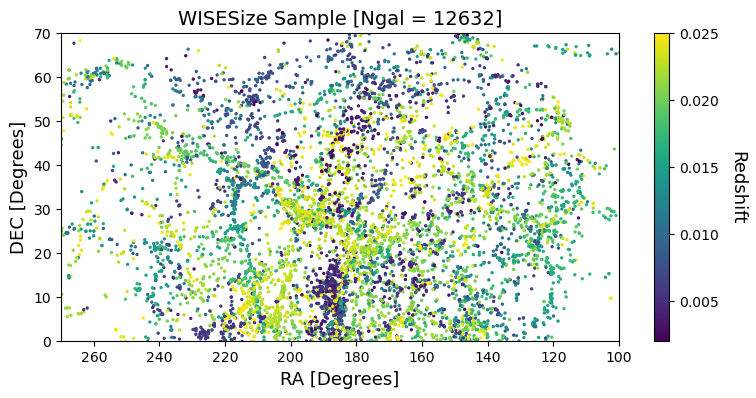

In [12]:
plt.figure(figsize=(9,4))
plt.scatter(ra,dec,c=z,s=2)
plt.xlim(270,100)
plt.ylim(0,70)
plt.clim(0.002,0.025)
cbar = plt.colorbar()
cbar.set_label('Redshift',fontsize=13,rotation=270,labelpad=20)
plt.xlabel('RA [Degrees]',fontsize=13)
plt.ylabel('DEC [Degrees]',fontsize=13)
plt.title(f'WISESize Sample [Ngal = {len(proposal_sample)}]',fontsize=14)
plt.show()

---

### NED-LVS 

In [4]:
#full NED-LVS sample (includes RA, DEC, redshifts, ...)
ned_sample = Table.read(homedir+'/Desktop/wisesize/NEDLVS_20210922_v2.fits')

#nedbyname --> contains row indices nedbyname["ROW"]
#nedgeometry --> GALAXY, MAG, MAG_REF, DIAM (in arcminutes!), DIAM_REF, BA, BA_REF, PA, PA_REF
nedgeometry = Table.read(homedir+'/Desktop/NEDgeometry-NEDLVS_20210922_v2.fits')
nedbyname = Table.read(homedir+'/Desktop/NEDbyname-NEDLVS_20210922_v2.fits')

In [ ]:
#I need diameters, so I will row-match the ned_sample to follow the indexing of the
#nedgeometry and nedbyname tables. the latter two tables are, in fact, missing 135 
#(or so?) galaxies.

ned_sample = ned_sample[nedbyname['ROW']]

In [6]:
#apply the sample cuts...

redshift_flag = (ned_sample['z']>0.002) & (ned_sample['z']<0.025)
ra_flag = (ned_sample['ra']>100.) & (ned_sample['ra']<270.)
dec_flag = (ned_sample['dec']>0.) & (ned_sample['dec']<70.)

#remove g_pair (galaxy pair) and g_trip objtypes
g_flag = (ned_sample['objtype']=='GPair') | (ned_sample['objtype']=='GTrpl')

In [7]:
#ned_sample = ned_sample[g_flag]
#nedgeometry = nedgeometry[g_flag]
#nedbyname = nedbyname[g_flag]

cut_ned_sample = ned_sample[redshift_flag&ra_flag&dec_flag&~g_flag]
print(len(cut_ned_sample))

31649


In [116]:
#np.unique(cut_ned_sample['objtype'])

Using TOPCAT, I then compared this table with the full z0MGS. Using RA, DEC and a max error of 2", I found 8002 matches in the case where GPair galaxies are retained and 7997 matches when GPair galaxies are removed.

In [ ]:
lvs_z0mgs = Table.read(homedir+'/Desktop/wisesize/z0mgs_LVS_matches_nogpair.fits')

Create z0mgs flag for LVS galaxies:

In [149]:
objname_matches = []
for obj in lvs_z0mgs['objname']:
    objname_matches.append(obj.strip())

In [150]:
z0mgs_match_flag = np.zeros(len(cut_ned_sample),dtype='bool')

for i in range(len(cut_ned_sample)):
    obj = cut_ned_sample['objname'][i].strip()
    if obj in objname_matches:
        z0mgs_match_flag[i] = True
    else:
        z0mgs_match_flag[i] = False

In [151]:
len(cut_ned_sample[z0mgs_match_flag])

7997

In [154]:
#cut_ned_sample[~z0mgs_match_flag].write(homedir+'/Desktop/wisesize/LVS_sample_noz0MGS_nogpair.fits')

Of the galaxies with no z0mgs matches, when compared with SGA-2020 I found 15257 matches (again used RA, DEC with a max error of 2") if gpairs are retained and 15238 matches if removed.

In [155]:
lvs_sga = Table.read(homedir+'/Desktop/wisesize/SGA2020_LVS_matches_nogpair.fits')

In [156]:
objname_matches = []
for obj in lvs_sga['objname']:
    objname_matches.append(obj.strip())

In [157]:
sga2020_match_flag = np.zeros(len(cut_ned_sample),dtype='bool')

for i in range(len(cut_ned_sample)):
    obj = cut_ned_sample['objname'][i].strip()
    if obj in objname_matches:
        sga2020_match_flag[i] = True
    else:
        sga2020_match_flag[i] = False

In [158]:
len(cut_ned_sample[sga2020_match_flag])

15238

In [159]:
print(f'Number of galaxies unspoken for: {len(cut_ned_sample[~sga2020_match_flag & ~z0mgs_match_flag])}')

Number of galaxies unspoken for: 26796


---

#### Evaluating NED-LVS diameters

In [37]:
#note again that these values are in ARCMINUTES
diam_full = nedgeometry['DIAM']

#flag to remove what I assume to be error diameters
err_flag = (diam_full<0.)

#diameters for either the full sample (w/out errs) or the WISESize cut sample (w/out errs)
diam_cut = diam_full[redshift_flag&ra_flag&dec_flag&~g_flag&~err_flag]
diam_full = diam_full[~err_flag]

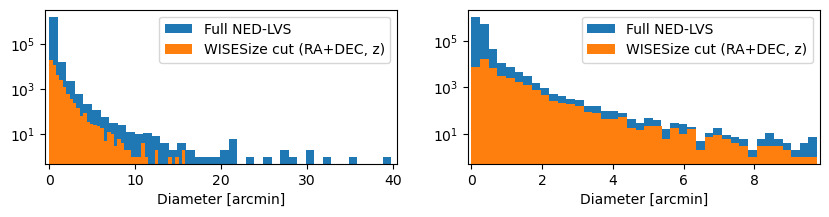

In [511]:
fig, ax = plt.subplots(1,2,figsize=(10,2))
ax1,ax2 = ax.flatten()

ax1.hist(diam_full[diam_full<40.],bins=40,label='Full NED-LVS')
ax1.hist(diam_cut[diam_cut<40.],bins=40,label='WISESize cut (RA+DEC, z)')
ax1.set_xlim(-0.5,40.5)
ax1.set_yscale('log')
ax1.set_xlabel('Diameter [arcmin]',fontsize=10)
ax1.legend()

ax2.hist(diam_full[diam_full<10.],bins=40,label='Full NED-LVS')
ax2.hist(diam_cut[diam_cut<10.],bins=40,label='WISESize cut (RA+DEC, z)')
ax2.set_xlim(-0.1,9.85)
ax2.set_yscale('log')
ax2.set_xlabel('Diameter [arcmin]',fontsize=10)
ax2.legend()

plt.show()

#### Comparing NED-LVS SFR, Mstar values with CIGALE results for VFS

In [8]:
#this table has VFID, NEDname (which I can compare with objname_2 of the same table), 
#SFR_W4, SFR_hybrid, Mstar
matched_tab = Table.read(dat_path+'VFS_NED_match.fits')

#all results from CIGALE run on VFS
cigale_tab = Table.read(homedir+'/Desktop/cigale_vf/out/results.fits')

In [9]:
#quickly define a function which generates a flag to ensure the catalogs are correctly comparable
def get_flags(cat1_VFID,cat2_VFID):
    flag1=[]
    flag2=[]
    for VFID in cat1_VFID:
        if VFID in cat2_VFID:
            flag1.append(True)
        else:
            flag1.append(False)
    for VFID in cat2_VFID:
        if VFID in cat1_VFID:
            flag2.append(True)
        else:
            flag2.append(False)
    return flag1, flag2

In [10]:
matched_VFID = matched_tab['VFID']
cigale_VFID = cigale_tab['id']   #has same VFID entries as negative version

In [11]:
#flags to ensure same VFIDs are in each array
flag_matched, flag_cigale = get_flags(matched_VFID, cigale_VFID)

In [12]:
#applying said flags
matched_tab = matched_tab[flag_matched]
cigale_tab = cigale_tab[flag_cigale]

In [13]:
matched_Mstar = np.log10(matched_tab['Mstar'])
matched_SFR = np.log10(matched_tab['SFR_hybrid'])
matched_SFR_W4 = np.log10(matched_tab['SFR_W4'])

cigale_Mstar = np.log10(cigale_tab['bayes.stellar.m_star'])
cigale_SFR = np.log10(cigale_tab['bayes.sfh.sfr'])

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_1682/2083607177.py:5: RuntimeWarning: invalid value encountered in log10
  cigale_Mstar = np.log10(cigale_tab['bayes.stellar.m_star'])
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_1682/2083607177.py:6: RuntimeWarning: invalid value encountered in log10
  cigale_SFR = np.log10(cigale_tab['bayes.sfh.sfr'])


In [14]:
#one more 'flag' --> migrate Virgo WISESize completeness cuts 
#log(Mstar)>8.3
#log(SFR)>-1.01

mstar_flag = (matched_Mstar>8.3) & (cigale_Mstar>8.3)
sfr_flag = (matched_SFR>-1.01) & (cigale_SFR>-1.01)

#NED-LVS SFRs are derived from scaling relationships, and "SFRs will be overestimated
#for quiescent, early-type galaxies. This flag marks galaxies affected to varying
#degrees.
ET_flag = matched_tab['ET_flag']

matched_Mstar_comp = matched_Mstar[mstar_flag]
matched_SFR_comp = matched_SFR[sfr_flag]
matched_SFR_W4_comp = matched_SFR_W4[sfr_flag]

cigale_Mstar_comp = cigale_Mstar[mstar_flag]
cigale_SFR_comp = cigale_SFR[sfr_flag]

matched_tab_comp_Mstar = matched_tab[mstar_flag]
matched_tab_comp_SFR = matched_tab[sfr_flag]

In [153]:
#rm_etypes --> removes early-type galaxies which may have overestimated LVS SFRs.
#cflag_chi --> colorbar which illustrates reduced chi-squared values.
#cflag_dist --> colorbar which illustrates offset distance from 1-to-1 lines.
#cflag_unc --> colorbar which illustrates SFR or Mstar uncertainties
#cflag_agn --> colorbar which illustrates frac_AGN according to CIGALE bayes results
#print_outlier_examples --> prints...outliers in the three designated plot regions.
def plot_comp(mstar_lvs, mstar_cig, sfr_lvs, sfr_cig, 
              cflag_chi=False, cflag_dist=False, cflag_unc=False, cflag_agn=False,
              rm_etypes=False, print_outlier_examples=False, vmin_unc=-2.5, vmax_unc=-0.6):

    #global matched_tab
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    fig.subplots_adjust(wspace=0.4,hspace=0.25)
    ax1, ax2 = ax.flatten()
    
    mstarflag=(~mstar_lvs.mask)   #only want to plot as many points as there are cmap vals
    sfrflag=(~sfr_lvs.mask)   #so I create masks according to cmap, not the data
    
    #remove early-type galaxies which may have overestimated LVS SFRs
    if rm_etypes:
        mstarflag=(~matched_tab['ET_flag'])&(~mstar_lvs.mask)
        sfrflag=(~matched_tab['ET_flag'])&(~sfr_lvs.mask)

    if cflag_dist:
        im1=ax1.scatter(mstar_lvs[sfrflag],mstar_lvs[sfrflag]-mstar_cig[sfrflag],
                        alpha=0.4,s=10,vmin=0,vmax=2,
                        c=np.abs(sfr_lvs[sfrflag]-sfr_cig[sfrflag]))
        im2=ax2.scatter(sfr_lvs[mstarflag],sfr_lvs[mstarflag]-sfr_cig[mstarflag],
                        alpha=0.4,s=10,vmin=0,vmax=0.8,
                        c=np.abs(mstar_lvs[mstarflag]-mstar_cig[mstarflag]),
                        label='UV+W4')
        
        fig.colorbar(im1, ax=ax1, label=r'log(SFR)$_{LVS}$ - log(SFR)$_{CIGALE}$')
        fig.colorbar(im2, ax=ax2, label=r'log(M$_*$)$_{LVS}$ - log(M$_*$)$_{CIGALE}$')
    
    elif cflag_unc:
        matched_tab_m=matched_tab if len(matched_tab)==len(mstar_lvs) else matched_tab_comp_Mstar
        im1=ax1.scatter(mstar_lvs[mstarflag],mstar_lvs[mstarflag]-mstar_cig[mstarflag],
                        alpha=0.4,s=10,
                        c=np.log10(matched_tab_m['Mstar_unc'][mstarflag])-mstar_lvs[mstarflag],
                        vmin=vmin_unc,vmax=vmax_unc)       
        
        matched_tab_s=matched_tab if len(matched_tab)==len(sfr_lvs) else matched_tab_comp_SFR
        im2=ax2.scatter(sfr_lvs[sfrflag],sfr_lvs[sfrflag]-sfr_cig[sfrflag],alpha=0.4,s=10,
                        c=np.log10(matched_tab_s['SFR_hybrid_unc'][sfrflag])-sfr_lvs[sfrflag],
                        vmin=vmin_unc,vmax=-1.4,label='UV+W4')
       
        fig.colorbar(im1, ax=ax1, label=r'log($\frac{\delta M_*}{M_*}$)$_{LVS}$')
        fig.colorbar(im2, ax=ax2, label=r'log($\frac{\delta SFR}{SFR}$)$_{LVS}$')
    
    elif cflag_chi:
        im1=ax1.scatter(mstar_lvs[mstarflag],mstar_lvs[mstarflag]-mstar_cig[mstarflag],
                        alpha=0.4,s=10,c=cigale_tab['best.reduced_chi_square'][mstarflag],
                        vmin=1.,vmax=1.5)
        
        im2=ax2.scatter(sfr_lvs[sfrflag],sfr_lvs[sfrflag]-sfr_cig[sfrflag],alpha=0.4,s=10,
                        c=cigale_tab['best.reduced_chi_square'][sfrflag],vmin=1.,vmax=1.5,label='UV+W4')
                        #c=np.log10(cigale_tab['bayes.sfh.sfr_err']/cigale_tab['bayes.sfh.sfr'])[sfrflag],
                        #label='UV+W4')
                        
        fig.colorbar(im1, ax=ax1, label=r'$\chi^2_{red}$')
        fig.colorbar(im2, ax=ax2, label=r'$\chi^2_{red}$')
        #fig.colorbar(im2, ax=ax2, label=r'log($\frac{\delta\text{SFR}}{\text{SFR}})_{CIGALE}$')
        
    elif cflag_agn:
        im1=ax1.scatter(mstar_lvs[mstarflag],mstar_lvs[mstarflag]-mstar_cig[mstarflag],
                        alpha=0.4,s=10,c=cigale_tab['bayes.agn.fracAGN'][mstarflag],
                        vmin=0.,vmax=0.15)
        im2=ax2.scatter(sfr_lvs[sfrflag],sfr_lvs[sfrflag]-sfr_cig[sfrflag],alpha=0.4,s=10,
                        c=cigale_tab['bayes.agn.fracAGN'][sfrflag],
                        vmin=0.,vmax=0.15,label='UV+W4')
        fig.colorbar(im1, ax=ax1, label=r'Bayes AGN fraction (CIGALE)')
        fig.colorbar(im2, ax=ax2, label=r'Bayes AGN fraction (CIGALE)')
    
    else:
        im1=ax1.scatter(mstar_lvs[mstarflag],mstar_lvs[mstarflag]-mstar_cig[mstarflag],
                        alpha=0.05)
        im2=ax2.scatter(sfr_lvs[sfrflag],sfr_lvs[sfrflag]-sfr_cig[sfrflag],
                        alpha=0.4,s=10,label='UV+W4')
    
    ax1.axhline(0,color='black',ls='--')
    ax1.set_xlabel(r'log(M$_*$)$_{LVS}$',fontsize=12)
    ax1.set_ylabel(r'log(M$_*$)$_{LVS}$ - log(M$_*$)$_{CIGALE}$',fontsize=12)

    #ax2.scatter(matched_SFR_W4,matched_SFR_W4-cigale_SFR,alpha=0.3,s=1,label='W4 Only')
    ax2.axhline(0,color='black',ls='--')
    ax2.set_xlabel(r'log(SFR)$_{LVS}$',fontsize=12)
    ax2.set_ylabel(r'log(SFR)$_{LVS}$ - log(SFR)$_{CIGALE}$',fontsize=12)

    #fitted lines
    xmin1,xmax1 = ax1.get_xlim()
    xmin2,xmax2 = ax2.get_xlim()

    x_p1 = np.linspace(xmin1,xmax1,50)
    x_p2 = np.linspace(xmin2,xmax2,50)

    p1 = np.poly1d(np.polyfit(mstar_lvs,mstar_lvs-mstar_cig,1))
    p2 = np.poly1d(np.polyfit(sfr_lvs,sfr_lvs-sfr_cig,1))

    ax1.plot(x_p1,p1(x_p1),color='crimson',label=f'Fit: m={np.round(p1[1],2)}')#, b={np.round(p1[0],2)}')
    ax2.plot(x_p2,p2(x_p2),color='crimson',label=f'Fit: m={np.round(p2[1],2)}')#, b={np.round(p2[0],2)}')
    
    ax2.axhline(np.median(np.abs(sfr_lvs[sfrflag]-sfr_cig[sfrflag])),color='purple',label='Median Offset')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    
    ax1.set_ylim(-2,4)
    
    plt.show()

    ###############
    
    print(f'Median Offset from stellar mass 1-to-1 Line: {np.median(np.abs(mstar_lvs[mstarflag]-mstar_cig[mstarflag])):.3f}')
    print(f'Median Offset from SFR 1-to-1 Line: {np.median(np.abs(sfr_lvs[sfrflag]-sfr_cig[sfrflag])):.3f}')
    print()
    print(f'STDEV stellar mass: {np.std(mstar_lvs[mstarflag]-mstar_cig[mstarflag]):.3f}')
    print(f'STDEV SFR: {np.std(sfr_lvs[sfrflag]-sfr_cig[sfrflag]):.3f}')
    
    ###############
    
    if print_outlier_examples:
        print()
        VFID_mstarcut = matched_tab['VFID'][mstarflag]
        VFID_sfrcut = matched_tab['VFID'][sfrflag]
        print('10 lower left Mstar outliers:')
        print(matched_tab['VFID'][((mstar_lvs-mstar_cig)<-1) & (mstar_lvs<8)][0:11])
        print()
        print('10 upper right Mstar outliers:')
        print(matched_tab['VFID'][((mstar_lvs-mstar_cig)>1) & (mstar_lvs>10)][0:11])
        print()
        print('10 upper SFR outliers:')
        print(matched_tab['VFID'][((sfr_lvs-sfr_cig)>4)][0:11])

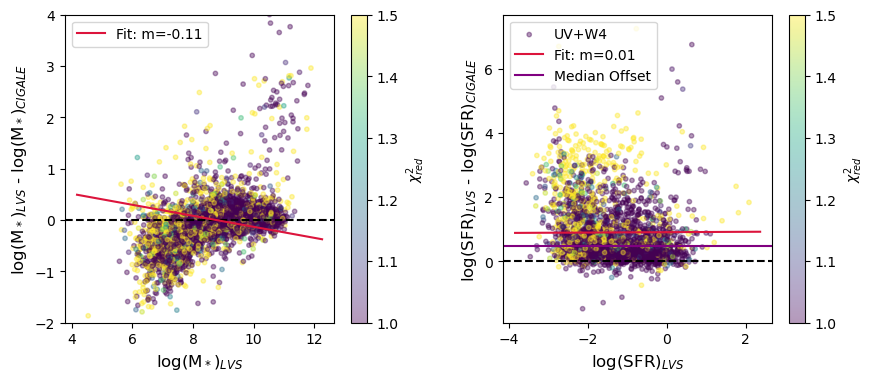

Median Offset from stellar mass 1-to-1 Line: 0.200
Median Offset from SFR 1-to-1 Line: 0.471

STDEV stellar mass: 0.576
STDEV SFR: 0.916


In [145]:
plot_comp(matched_Mstar,cigale_Mstar,matched_SFR,cigale_SFR,cflag_chi=True)

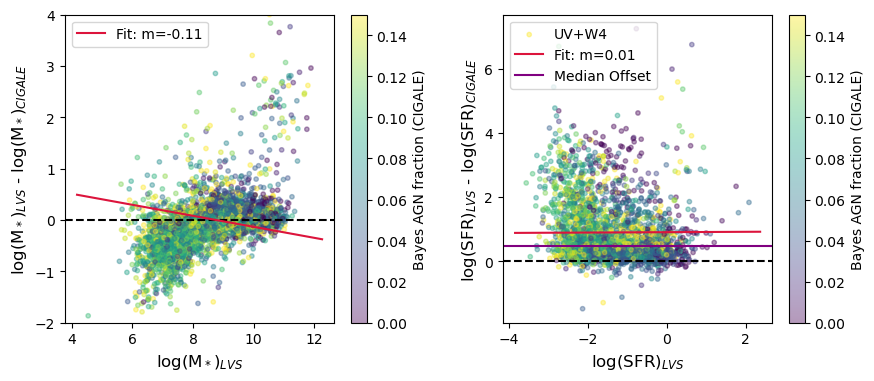

Median Offset from stellar mass 1-to-1 Line: 0.200
Median Offset from SFR 1-to-1 Line: 0.471

STDEV stellar mass: 0.576
STDEV SFR: 0.916


In [146]:
plot_comp(matched_Mstar,cigale_Mstar,matched_SFR,cigale_SFR,cflag_agn=True,rm_etypes=False)

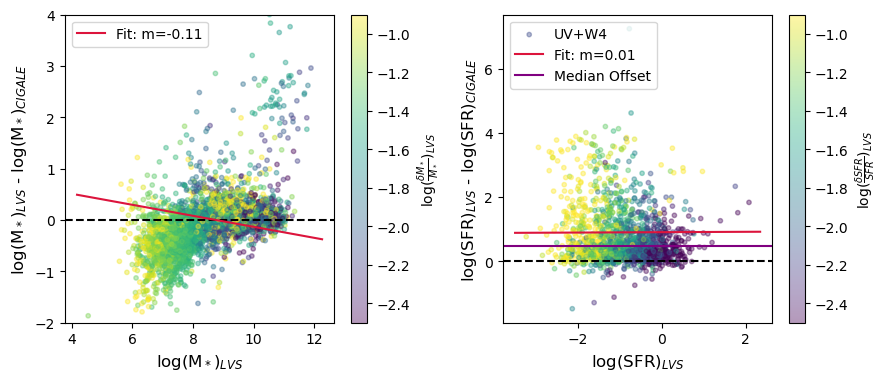

Median Offset from stellar mass 1-to-1 Line: 0.200
Median Offset from SFR 1-to-1 Line: 0.471

STDEV stellar mass: 0.576
STDEV SFR: 0.916


In [19]:
plot_comp(matched_Mstar,cigale_Mstar,matched_SFR,cigale_SFR,cflag_unc=True,rm_etypes=False,
         vmin_unc=-2.5, vmax_unc=-0.9)

In [ ]:
plot_comp(matched_Mstar,cigale_Mstar,matched_SFR,cigale_SFR,cflag_dist=True,rm_etypes=False,
         print_outlier_examples=True)

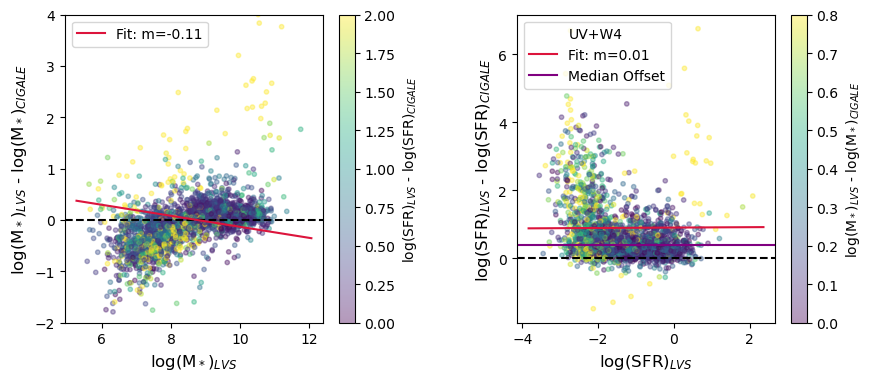

Median Offset from stellar mass 1-to-1 Line: 0.226
Median Offset from SFR 1-to-1 Line: 0.395

STDEV stellar mass: 0.540
STDEV SFR: 0.770


In [150]:
plot_comp(matched_Mstar,cigale_Mstar,matched_SFR,cigale_SFR,cflag_dist=True,rm_etypes=True)

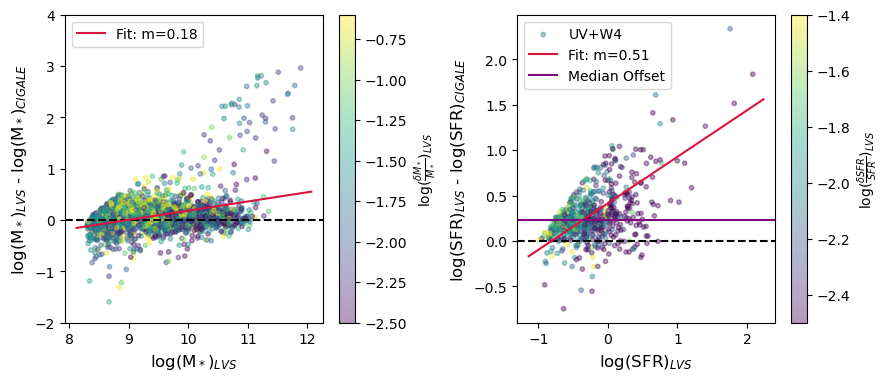

Median Offset from stellar mass 1-to-1 Line: 0.135
Median Offset from SFR 1-to-1 Line: 0.235

STDEV stellar mass: 0.353
STDEV SFR: 0.291


In [154]:
#reminder --> "comp" refers to the Virgo WISESize SFR, Mstar cuts

plot_comp(matched_Mstar_comp,cigale_Mstar_comp,
          matched_SFR_comp,cigale_SFR_comp,cflag_unc=True)

##### SEE NOTEBOOK FOR SUMMARIES.

----

### Misc. code to take VFS+NED table, the union of which being courtesy of TOPCAT, and add a row-matched VFS membership flag to the NED-LVS table. Do the same with RA+DEC, redshift, and SNR flags.

In [ ]:
#might require a few minutes to run

match = Table.read(homedir+'/Desktop/wisesize/VFS_NED_match.fits')
obj=match['objname_2']
counter=0
for i in range(len(obj)):
    obj[i] = obj[i].strip()
VFS_flag = []
for i in ned_sample['objname']:
    if i.strip() in obj:
        VFS_flag.append(True)
        counter+=1
        #print(counter)
    else:
        VFS_flag.append(False)
ned_sample['VFS_flag'] = VFS_flag

In [ ]:
nedlvs_flag = Table([ned_sample['objname'],ned_sample['ra'],ned_sample['dec'],
                    ned_sample['VFS_flag']],names=['objname','ra',
                    'dec','VFS_flag'])

In [ ]:
#add redshift_flag column
zflag = (ned_sample['z']>0.002) & (ned_sample['z']<0.025)
nedlvs_flag['z_flag'] = zflag

In [ ]:
#add radec_flag column
#ra_flag = (ned_sample['ra']>100.) & (ned_sample['ra']<270.)
ra_flag = (ned_sample['ra']>87.) & (ned_sample['ra']<300.)
#dec_flag = (ned_sample['dec']>0.) & (ned_sample['dec']<70.)
dec_flag = (ned_sample['dec']>-10.) & (ned_sample['dec']<85.)
nedlvs_flag['radec_flag'] = ra_flag&dec_flag

In [ ]:
#add SNR flags (SNR(NUV)>20 *or* SNR(W3)>20)
snr_nuv_flag = (ned_sample['Lum_NUV'] / ned_sample['Lum_NUV_unc']) > 20.
snr_w3_flag = (ned_sample['Lum_W3'] / ned_sample['Lum_W3_unc']) > 20.
nedlvs_flag['snr_nuv_flag'] = snr_nuv_flag
nedlvs_flag['snr_w3_flag'] = snr_w3_flag
snr_combined_flag = ((snr_nuv_flag.data==True) | (snr_w3_flag.data==True))

diam_flag = ((diam_full*60.)>15.) | ((diam_full*60.)<0.)

nedlvs_flag['diam_flag'] = diam_flag
nedlvs_flag['snr_combined_flag'] = snr_combined_flag
nedlvs_flag['diam_arcmin'] = diam_full

#add size cut --> >15"

In [ ]:
allflags = snr_combined_flag & ~np.asarray(VFS_flag) & ra_flag & dec_flag & zflag & diam_flag
#nedlvs_flag.remove_column('all_flags')
nedlvs_flag['all_flags'] = allflags

In [ ]:
nedlvs_flagged = nedlvs_flag[nedlvs_flag['all_flags']]

In [ ]:
nedlvs_flagged.write(homedir+'/Desktop/LVS_sample.fits',overwrite=True)

In [355]:
np.round(np.modf(1.202)[0],3)

0.202

In [356]:
from astropy.io import fits

In [563]:
v,header=fits.getdata(homedir+'/github/unwise_psf/py/unwise_psf/data/psf_model_w2_neo7_unwisecat.fits',header=True)